In [23]:
%load_ext autoreload
%autoreload 2

import os, pickle, random, sbmtm
# import seaborn as sns; sns.set(style="white", color_codes=True) # is not installed on system, just folder in this directory
import numpy as np
import pandas as pd
from sbmtm import sbmtm
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple approach to detect time-dependence

- simply look at fraction of articles in each doc-cluster (these are groups after all)
- now separate the data into 2 parts (or more) according to timestamp.
- plot the fraction/cluster; or even entropy for each segment
- COMPARE with null model where order is randomized
--> this allwos us to detect whether there is **any** non-stationarity in the timeseries of posts.

- I played with a few datasets. If there is some time-dependence above the null model, it is very weak. This would suggest that the order of the articles (or their 'topics') are not distinguishable from random

In [2]:
path_read = 'cleaned_posts/'

fname_read = 'TRAINING-10149142-the-family-fang.json'
# fname_read = 'TRAINING-16126596-the-people-in-the-trees.json'
# fname_read = 'TRAINING-18652002-the-bees.json'
# fname_read = 'TRAINING-20575425-wolf-in-white-van.json'
filename = os.path.join(path_read,fname_read)

with open(filename,"r",encoding="utf8") as f:
    df = pd.DataFrame(pd.read_json(f))
    
## order according to delta
df = df.sort_values(by='delta')


cleaned_posts/TRAINING-10149142-the-family-fang.json


In [4]:
m_min = 100 ## minimum text length
df = df[df['word_count']>=m_min]

list_texts = list(df['doc'])
list_texts = [ h for h in  df['doc']]

list_titles = list(df.index)
list_delta = list(df['delta'])
len(list_texts)
D = len(list_texts)
D

226

In [5]:
## fit the model
model = sbmtm()
model.make_graph(list_texts,documents = list_titles)
model.fit(B_min=3)

Reached 0th node


In [6]:
chosen_level=1

In [7]:
## group membership of doc-, and word-nodes
p_td_d,p_tw_w = model.group_membership(l=chosen_level)

D = model.get_D() ## number of documents
B_d = len(p_td_d[:,0]) ## number of doc-groups
B_w = len(p_tw_w[:,0]) ## number of word-groups

list_b_d = np.argmax(p_td_d,axis=0)


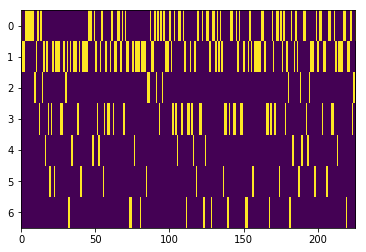

In [8]:
plt.imshow(p_td_d,aspect='auto')

In [19]:
N_s = 2 ## number of splits of the datasets (acording to time-stamp
n_rep = 100 ## number of randomizations when shuffling the order of the articles

p_b_s = np.zeros(( N_s,B_d ))

x = np.array_split(list_b_d,N_s)
for i_s in range(N_s):
    x_tmp  = x[i_s]
    c = Counter(x_tmp)
    for b,n_b in c.items():
        p_b_s[i_s,b] = n_b/len(x_tmp)
        
p_b_s_random = np.zeros((n_rep, N_s,B_d ))

list_b_d_random = np.copy(list_b_d)
for i_n_rep in range(n_rep):
    np.random.shuffle(list_b_d_random)
    x = np.array_split(list_b_d_random,N_s)
    for i_s in range(N_s):
        x_tmp  = x[i_s]
        c = Counter(x_tmp)
        for b,n_b in c.items():
            p_b_s_random[i_n_rep,i_s,b] = n_b/len(x_tmp)

Text(0.5,0,'Time-segment')

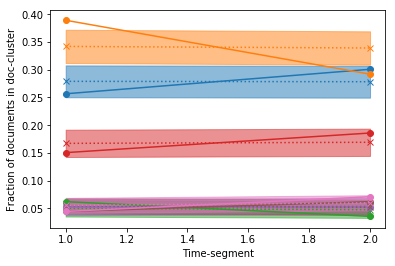

In [24]:
## proportion of documents in each doc-cluster,
## plotted as a function of 'time' over equal-sized segments of the data
cm = plt.get_cmap('tab10')

for i_b in range(B_d):
    
    c_ = cm(i_b)
    x_ = np.arange(N_s)+1
    y_ = p_b_s[:,i_b]
    plt.plot(x_,y_,marker='o',c=c_)
    
    
    x_ = np.arange(N_s)+1
    z_= p_b_s_random[:,:,i_b]
    y_ = np.mean(z_,axis=0)
    yerr_ = np.std(z_,axis=0)
    plt.plot(x_,y_,marker='x',ls=':',c=c_)
    y1_ = y_-yerr_
    y2_ = y_+yerr_
    plt.fill_between(x_,y1_,y2_,alpha=0.5,color=c_)
#     plt.errorbar()
    
plt.ylabel('Fraction of documents in doc-cluster')
plt.xlabel('Time-segment')

Text(0.5,0,'Time-segment')

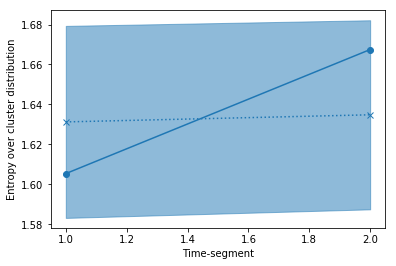

In [21]:
## entropy over the cluster-size distribution over time
c_ = cm(0)
H = -np.nansum(p_b_s*np.log(p_b_s),axis=1)
x_ = np.arange(N_s)+1
y_ = H
plt.plot(x_,y_,marker='o',c=c_)

H_random = -np.nansum(p_b_s_random*np.log(p_b_s_random),axis=2)
H_random_mu = np.mean(H_random,axis=0)
H_random_std = np.std(H_random,axis=0)
x_ = np.arange(N_s)+1
y_ = H_random_mu
yerr_ = H_random_std
plt.plot(x_,y_,marker='x',ls=':',c=c_)
y1_ = y_-yerr_
y2_ = y_+yerr_
plt.fill_between(x_,y1_,y2_,alpha=0.5,color=c_)
plt.ylabel('Entropy over cluster distribution')
plt.xlabel('Time-segment')

In [18]:
# model.topics(l=chosen_level)